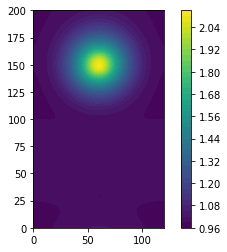

In [9]:
import math

from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt

comm = MPI.comm_world
rank = MPI.rank(comm)
import numpy as np

data = HDF5File(comm, f"data_test_35.h5", 'r')

mesh = Mesh()
data.read(mesh, "mesh", False)

nx = 60
ny = 100
LX = 120 
LY = 200

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY
            
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
w = Function(FS)

(rho_new, tau_new) = split(u_new)


t = 2999
data.read(u_new, f"u_new/Vector/vector_35_{t}")

c = plot(rho_new)
plt.colorbar(c)

In [50]:
theta = Function(FS)

interval = 15
start = 2980
end = start + interval



def calculate_theta(taux, tauy):

    theta = Function(FS)


    for i in range(len(theta.vector()[:])):
        theta.vector()[i] = np.arctan2(tauy.vector()[i], taux.vector()[i])
        
        
    return theta


def fenics_to_numpyarray(rho):
    
    x = np.linspace(0, LX, LX)
    y = np.linspace(0, LY, LY)
    xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')
    
    rho_ = project(rho, FS)
    rho_vec = np.vectorize(rho_)
    rho_ar = rho_vec(xx, yy)
    
    return rho_ar


def calculate_phi(x0, y0):

    phi = np.zeros([LX, LY])

    for x in range(LX):
        for y in range(LY):
            
            if x != x0:  # To avoid division by zero
                phi[x, y] = math.atan2((y - y0), (x - x0))
            elif y > y0:
                phi[x, y] = math.pi / 2
            elif y < y0:
                phi[x, y] = -math.pi / 2
            else:
                phi[x, y] = 0.0
                
    return phi



def create_circular_mask(rows, cols, center, radius):
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = distance <= radius
    return mask



theta_total = np.zeros([LX*LY, interval])
phi_total = np.zeros([LX*LY, interval])







for t in range(start, end):
    
    print(f"step : {t}", flush = True)
    
    data.read(u_new, f"u_new/Vector/vector_35_{t}")

    taux = project(tau_new[0]/rho_new, FS)
    tauy = project(tau_new[1]/rho_new, FS)

    theta = calculate_theta(taux, tauy)

    theta_ar = fenics_to_numpyarray(theta)
    rho_ar   = fenics_to_numpyarray(rho_new)



    max_value = np.max(rho_ar)
    max_index = np.unravel_index(np.argmax(rho_ar), rho_ar.shape)

    x0 = max_index[0]
    y0 = max_index[1]


    phi = calculate_phi(x0, y0)
    # Parameters
    center_x = x0
    center_y = y0
    radius = 10

    # Create a circular mask
    mask = create_circular_mask(LY, LX, (center_x, center_y), radius)

    # Create a sample array
    input_array = rho_ar.T

    # Apply the mask
    masked_array = np.where(mask, input_array, 0)

    theta_new  = np.where(mask, theta_ar.T, 0) # polarization vector 

    
    ############################################
    phi_new = np.where(mask, phi.T, 0) # polar axis 

    phi_flat = phi_new.flatten()
    theta_flat = theta_new.flatten()

    # Example data
    x = phi_flat
    y = theta_flat

    # Sort the x array and store the corresponding order indices
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    sorted_x = [x[i] for i in sorted_indices]
    sorted_y = [y[i] for i in sorted_indices]
    
    
    phi_total[:, t - start] = sorted_x
    theta_total[:, t - start] = sorted_y

# Create the plot
# plt.plot(sorted_x, sorted_y, marker = 'o', linestyle='-', color='b')
# plt.xlabel(r'$\phi$', fontsize = 20)
# plt.ylabel(r'$\theta$', fontsize = 20)

# plt.axvline(x = 0, linestyle = '--', color = 'k')
# plt.axhline(y = 0, linestyle = '--', color = 'k')
# plt.tick_params(axis = 'both', labelsize = 20)
# plt.show()

step : 2980
step : 2981
step : 2982
step : 2983
step : 2984
step : 2985
step : 2986
step : 2987
step : 2988
step : 2989
step : 2990
step : 2991
step : 2992
step : 2993
step : 2994


In [52]:
phi_ = np.sum(phi_total, axis  = 1)/interval

theta_ = np.sum(theta_total, axis  = 1)/interval

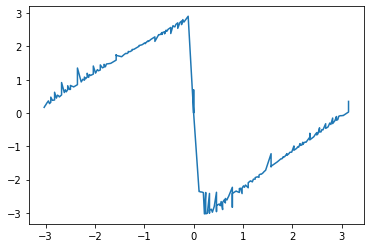

In [53]:
plt.plot(phi_, theta_)

In [66]:
print(np.power(0.93, 1/5))

0.9855906837939876


In [67]:
np.power(0.9855, 200)

0.053867363904658384